# EE 519 — Speech AI
## HW-1 | Notebook 4: Fourier Analysis — Sinusoids, DFT/FFT, Spectra of Speech

**Student Name:**  Kobe Kodachi

**USC ID:**  7134744658

**Date:**  2/3/2026

---

### Learning Objectives
By completing this notebook, you will:
- Build intuition that **sinusoids are building blocks** of signals
- Implement and interpret **DFT/FFT** for synthetic and speech signals
- Understand how **window length** and **window type** affect spectra
- Connect speech acoustics (harmonics + spectral envelope) to frequency-domain views

> ⚠️ **Important**
> - All answers (code + explanations) must be written **inside this notebook**
> - Do **not** delete questions or prompts
> - Clearly label all plots (title, axes, units)
> - Use **relative paths only** for audio


### Grading (Notebook 4 — 20 points)

| Component | Points |
|---|---:|
| Correct FFT/DFT implementation + clean plots | 6 |
| Synthetic sinusoid experiments (time + freq) | 5 |
| Speech frame spectral analysis + window effects | 6 |
| Conceptual explanations (resolution, leakage, envelope vs harmonics) | 2 |
| Clarity & organization | 1 |

> We grade **understanding and reasoning**, not perfection.


---

# 0. Setup (Reproducibility)

This notebook must run quickly for grading.

## ✅ Reproducibility requirements
- Put audio files in the same folder as the notebook or in `./audio/`
- Use **relative paths only**
- Do not rely on cloud mounts or absolute paths

Recommended structure:
```
HW1/
├── HW1_Notebook4_Fourier_DFT_SpeechSpectra.ipynb
└── audio/
    └── x.wav
```

## Data requirement
You need **one** speech recording `x` (sentence recommended) at `./audio/x.wav`.
You may reuse the same `x.wav` from Notebook 3.


In [ ]:
# TODO: Imports
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display


In [2]:
# TODO: Audio path
X_PATH = "./audio/x.wav"


In [4]:
# TODO: WAV loader (reuse from Notebook 1/3)
import os
from scipy.io import wavfile

def to_mono(x):
    """Ensure mono float32 in [-1, 1]."""
    x = np.asarray(x)
    if x.ndim == 2:  # stereo -> mono
        x = x.mean(axis=1)
    if np.issubdtype(x.dtype, np.integer):
        maxv = np.iinfo(x.dtype).max
        x = x.astype(np.float32) / maxv
    else:
        x = x.astype(np.float32)
    return np.clip(x, -1.0, 1.0)

def load_wav(path):
    if not os.path.exists(path):
        # print(f"File not found: {path}\nUpload a WAV and update wav_path.")
        raise FileNotFoundError(f"File not found: {path}")
    else:
        fs, x = wavfile.read(path)
        x = to_mono(x)
        print("Loaded:", path)
        print("Sampling rate (Hz):", fs)
        print("Duration (s):", len(x)/fs)
        print(f"Min/max amplitude: {x.min():.3f}/{x.max():.3f}")
        return x, fs


In [5]:
# TODO: Load audio
x, fs = load_wav(X_PATH)
print(fs, len(x)/fs, x.min(), x.max())
display(Audio(x, rate=fs))


Loaded: ./audio/x.wav
Sampling rate (Hz): 16000
Duration (s): 4.0
Min/max amplitude: -0.648/1.000
16000 4.0 -0.6476028 1.0


In [35]:
# TODO: Helper plotting utilities
def plot_waveform(x, fs, title="Waveform", tlim=None):
    # raise NotImplementedError
    t = np.arange(len(x)) / fs
    plt.figure(figsize=(10, 2))
    plt.plot(t, x, linewidth=0.8)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")    
    plt.title(title)
    if tlim is not None:
        plt.xlim(tlim)
    plt.show()

def magnitude_spectrum(x, fs, window=None):
    """Return f axis (Hz) and magnitude spectrum (linear or dB)."""
    # raise NotImplementedError
    n = len(x)
    if not window:
        x_w = x
    elif window == "hann":
        x_w = x * np.hanning(n).astype(np.float32)
    elif window == "hamming":
        x_w = x * np.hamming(n).astype(np.float32)

    # compute fft and freq axis
    X = np.fft.rfft(x_w)
    freqs = np.fft.rfftfreq(n, d=1/fs)
    mag = 20*np.log10(np.abs(X) + 1e-12)
    return freqs, mag

def plot_spectrum(f, mag):
    plt.figure(figsize=(12, 4))
    plt.plot(f, mag, linewidth=1.0)
    plt.title("Magnitude vs Frequency")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.xlim(0, fs/2)
    plt.grid(True)
    plt.show()



---

# 1. Sinusoids: Time Domain → Frequency Domain

In this section you will generate:
- A single sine wave
- Multiple sine waves (a sum of tones)

Then you will inspect:
- Time-domain waveform
- Magnitude spectrum

### Notes
- Use a clean sampling rate (e.g., 16 kHz)
- Use a fixed duration (e.g., 1 second)


In [11]:
# TODO: Define a sampling rate and duration for synthetic signals
fs_syn = 16000
duration_sec = 1.0
t = np.arange(int(fs_syn * duration_sec)) / fs_syn


## 1.1 Single sine wave

### Task
Generate a sine wave at a chosen frequency (e.g., 440 Hz).
- Plot 20 ms of the waveform
- Plot its magnitude spectrum
- Identify where the spectral peak occurs


In [12]:
# TODO: Single sine
f0 = 440
x_sine = np.sin(2*np.pi*f0*t)


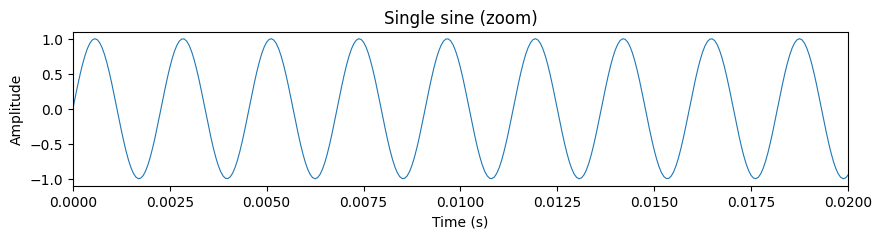

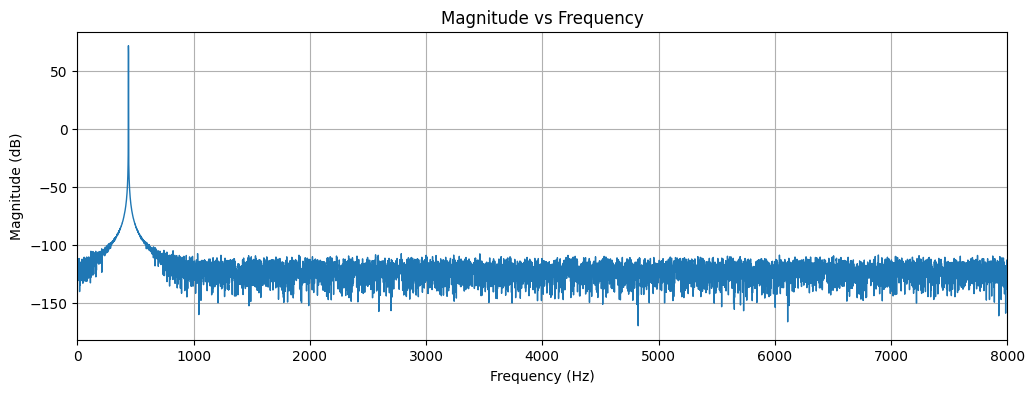

In [21]:
# TODO: Plot waveform (zoom) and spectrum
plot_waveform(x_sine, fs_syn, "Single sine (zoom)", tlim=(0, 0.02))
f, mag = magnitude_spectrum(x_sine, fs_syn, window="hann")
plot_spectrum(f,mag)


### Questions (Single sine)

1. Where is the peak in the spectrum? Is it exactly at your chosen frequency? Why might it differ slightly?  
2. What happens to the spectrum if you shorten the signal duration to 0.1 seconds? (Try and explain.)


1. It looks to be around 440 but not exactly. This could be because if the frequency is not exactly in a bin it will be spread across nearby bins.
2. The length of x decreases which causes the number of bin spacing to increase. This makes the graph look wider.

## 1.2 Sum of multiple sines

### Task
Create a signal that is the sum of 3–5 sine waves at different frequencies.
- Plot waveform (zoom)
- Plot spectrum
- Create a small table: frequency → amplitude used → observed peaks


In [16]:
# TODO: Sum of sines
freqs = [200, 400, 800, 1600]  # example
amps  = [1.0, 0.6, 0.4, 0.2]   # example
x_sum = np.zeros_like(t)
for f0, a in zip(freqs, amps):
    x_sum += a*np.sin(2*np.pi*f0*t)


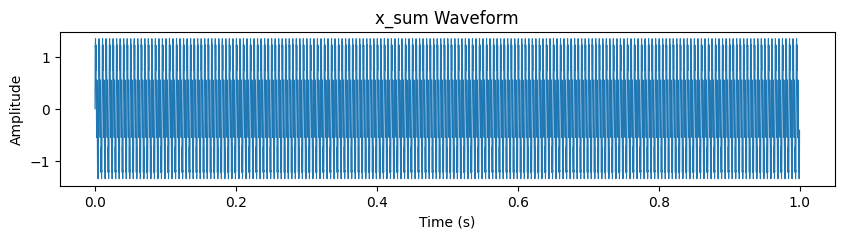

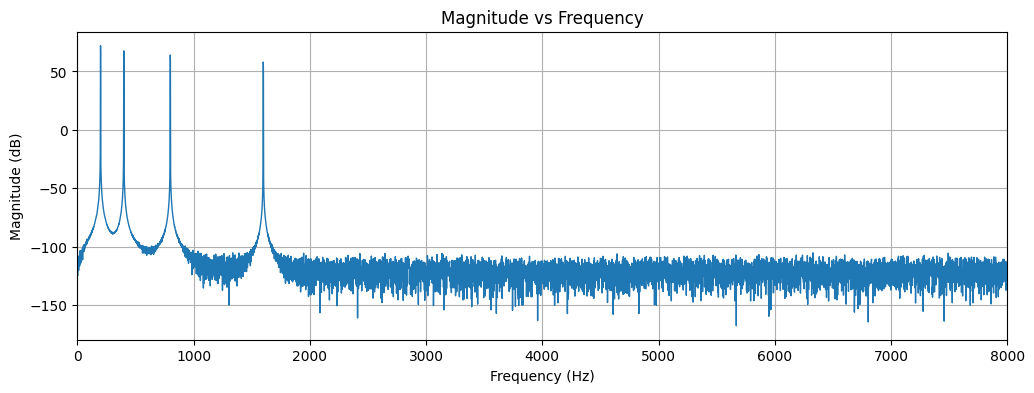

Expected vs Observed Peaks:
 Expected Hz | Amplitude used | Observed Peak (Hz) |  Observed Magnitude (dB)
---------------------------------------------------------------------------
         200 |            1.0 |              200.0 |                  -105.74
         400 |            0.6 |              385.0 |                   -81.53
         800 |            0.4 |              799.0 |                  -109.01
        1600 |            0.2 |             1601.0 |                  -116.24


In [22]:
# TODO: Plot waveform and spectrum; create your small summary table in markdown
plot_waveform(x_sum,fs,"x_sum Waveform")
f, m = magnitude_spectrum(x_sum,fs,"hann")
plot_spectrum(f,m)
from scipy.signal import find_peaks

peaks, _ = find_peaks(mag)
observed_freqs = f[peaks]
observed_mags = mag[peaks]

print("Expected vs Observed Peaks:")
print(f"{'Expected Hz':>12} | {'Amplitude used':>14} | {'Observed Peak (Hz)':>18} | {'Observed Magnitude (dB)':>24}")
print("-"*75)
for f_exp, a in zip(freqs, amps):
    # find closest observed peak
    idx = np.argmin(np.abs(observed_freqs - f_exp))
    print(f"{f_exp:12} | {a:14} | {observed_freqs[idx]:18.1f} | {observed_mags[idx]:24.2f}")

### Questions (Sum of sines)

1. Does the time-domain waveform look “simple” or “complex”?  
2. Why does the frequency-domain view make the signal easier to describe?  
3. If two sine waves are very close in frequency, when do they become hard to separate in FFT? (Connect to resolution.)


### Answers

1. It looked complex at first but after changing my waveform function I realized the same pattern was repeating so I would say it looks simple.
2. It shows the peaks around the expected Hz so we can recognize the effects of the input.
3. They would likely fight for the same set of bins so it would be hard to distinguish them.

---

# 2. DFT/FFT Details: Resolution, Leakage, and Windows

### Key concepts you will explore
- **Frequency resolution** depends on signal length (N) and fs: Δf = fs / N
- **Spectral leakage** occurs when frequencies do not align with FFT bins
- **Windowing** reduces leakage but changes main-lobe width and amplitude

In this section you will run controlled experiments to see these effects.


## 2.1 Resolution experiment

### Task
Generate two sine waves close in frequency (e.g., 1000 Hz and 1050 Hz).
Compute spectra for:
- N = 0.02 sec, 0.05 sec, 0.1 sec (choose 3 lengths)

Describe when the two peaks become separable.


Delta f: 50.0


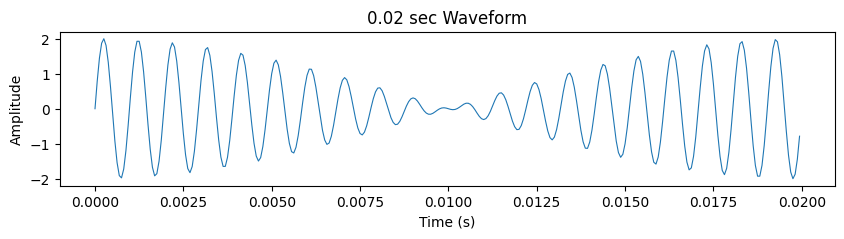

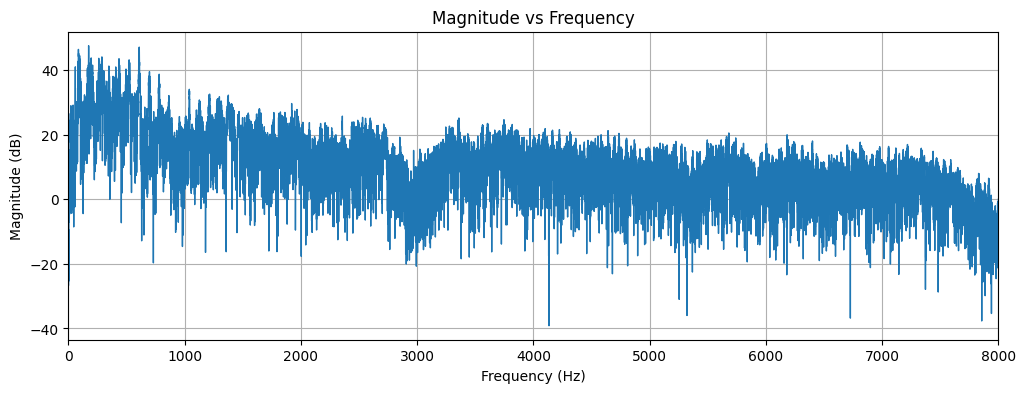

Delta f: 20.0


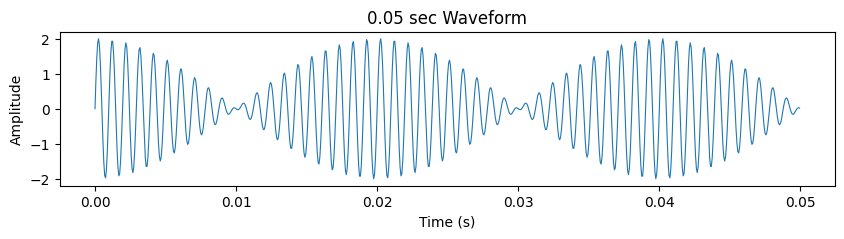

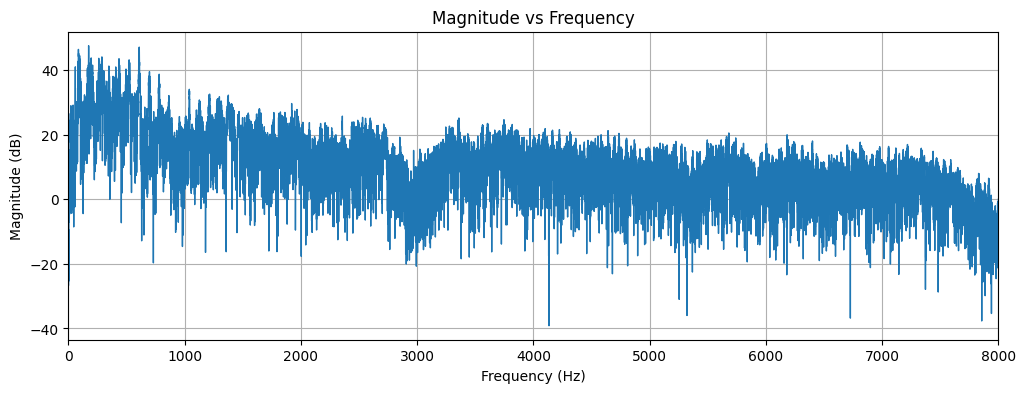

Delta f: 10.0


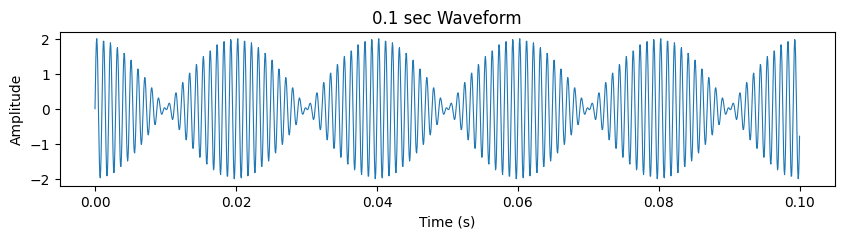

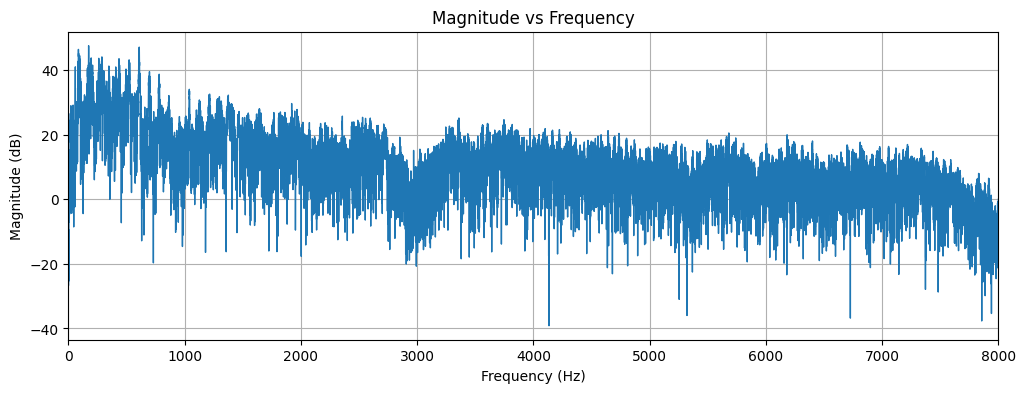

In [24]:
# TODO: Resolution experiment
f1, f2 = 1000, 1050
lengths_sec = [0.02, 0.05, 0.1]
# For each length:
#   generate x_len
#   compute spectrum
#   plot and compare

for l in lengths_sec:
    t = np.arange(0, l, 1/fs)
    x_l = np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t)
    f, mag = magnitude_spectrum(x, fs, "hann")
    N = int(l * fs)
    print(f"Delta f: {fs / N}")
    plot_waveform(x_l,fs,f"{l} sec Waveform")
    plot_spectrum(f,mag)


### Questions (Resolution)

- For each length, compute Δf = fs / N and report it.
- Which length gives the clearest separation? Why?


### Answers

- From above we get 50, 20, and 10.
- They all look pretty separated but the 0.1 second waveform shows the pattern repeating for longer.


## 2.2 Leakage experiment (bin misalignment)

### Task
Pick a sine frequency that is **not** an integer multiple of Δf (e.g., 997 Hz).
Compute FFT:
- with rectangular window (no window)
- with Hann window

Compare leakage patterns.


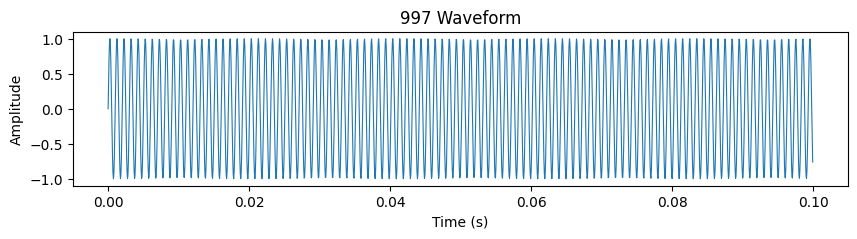

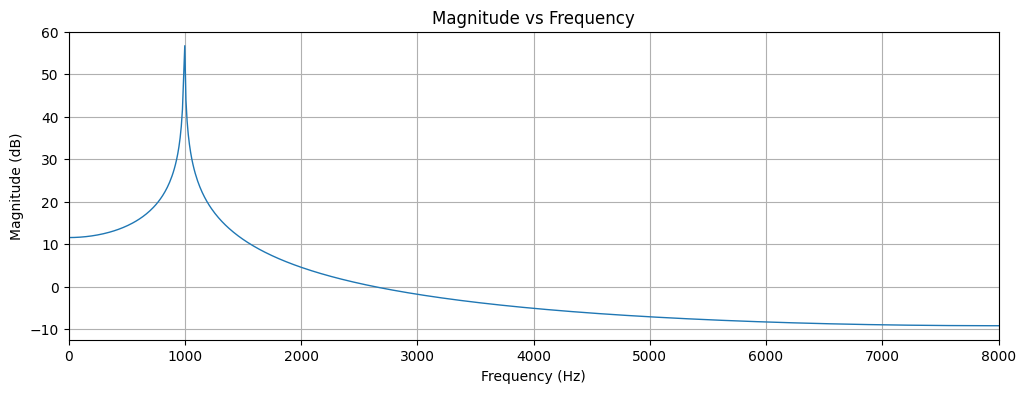

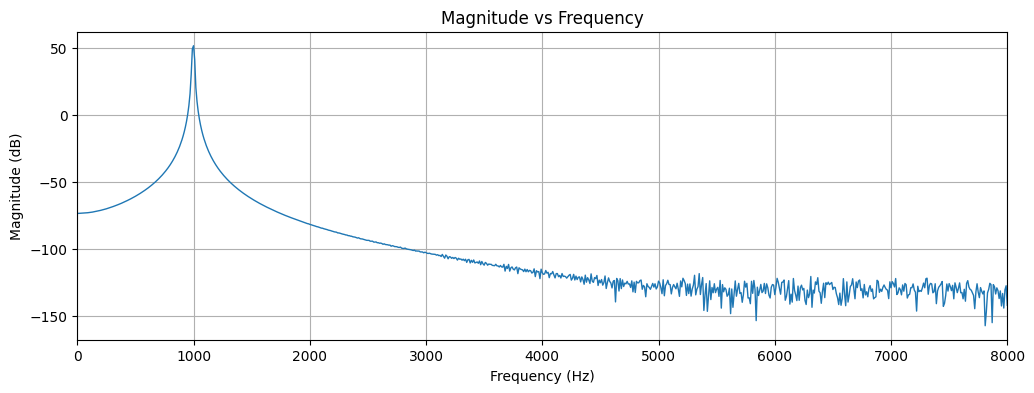

In [29]:
# TODO: Leakage experiment
f0 = 997
x = x = np.sin(2*np.pi*f0*t)
# Compute spectra with window=None vs window="hann"
# Plot and compare
plot_waveform(x,fs,f"{f0} Waveform")
f_, m = magnitude_spectrum(x,fs)
plot_spectrum(f_,m)
f_, m = magnitude_spectrum(x,fs,"hann")
plot_spectrum(f_,m)

### Questions (Leakage & windows)

1. What changes when you apply a Hann window?  
2. What tradeoff do you observe (leakage vs main-lobe width / peak sharpness)?  
3. Why is windowing important for short-time speech spectra?


### Answers

1. The right side of the hann window has more noise than the rectangular window.
2. We can see than the peak of the hann window is less sharp and wider than the rectangular window. There is less leakage as well.
3. Windowing reduces leakage that comes from short-time speech processing. This helps when we analyze the speech.

---

# 3. Speech Spectrum: Harmonics vs Spectral Envelope

Speech contains:
- **Harmonics** (from voiced excitation) → equally spaced by fundamental frequency
- **Spectral envelope** (from vocal-tract filtering / formants)

In this section, you will select a short speech segment and compute its spectrum.


## 3.1 Select a voiced segment

### Task
Pick a 30–50 ms segment from your speech that is clearly voiced (e.g., a vowel region).
- Provide start and end times (seconds)
- Plot waveform zoom
- Play the segment


Loaded: audio/x.wav
Sampling rate (Hz): 16000
Duration (s): 4.0
Min/max amplitude: -0.648/1.000


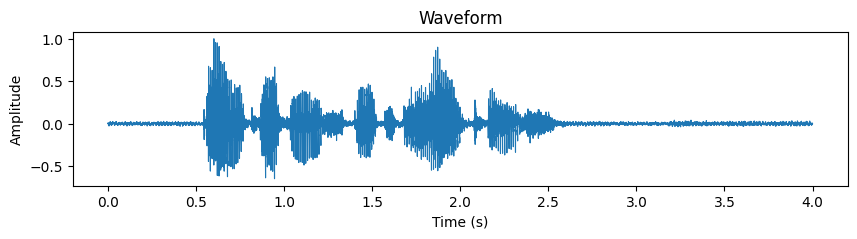

In [48]:
# TODO: Choose voiced segment times (in seconds)
x, fs = load_wav("audio/x.wav")
plot_waveform(x,fs)
t_start = 1.9
t_end = 1.95

# Extract:
n0 = int(t_start*fs); n1 = int(t_end*fs)
x_seg = x[n0:n1]


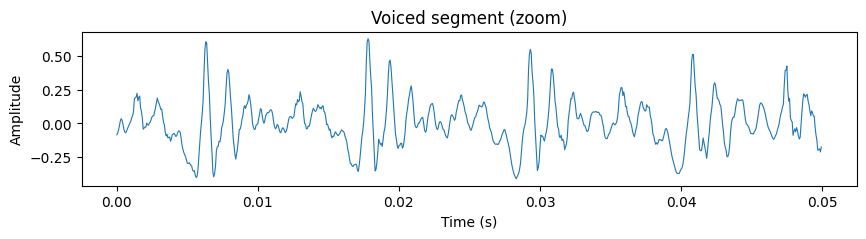

In [46]:
# TODO: Plot and play segment
plot_waveform(x_seg, fs, "Voiced segment (zoom)")
display(Audio(x_seg, rate=fs))


## 3.2 Spectrum of voiced segment

### Task
Compute and plot the magnitude spectrum of the segment:
- rectangular window
- Hann window

Use the same FFT size for fair comparison.

Then answer questions about:
- harmonic spacing
- envelope shape


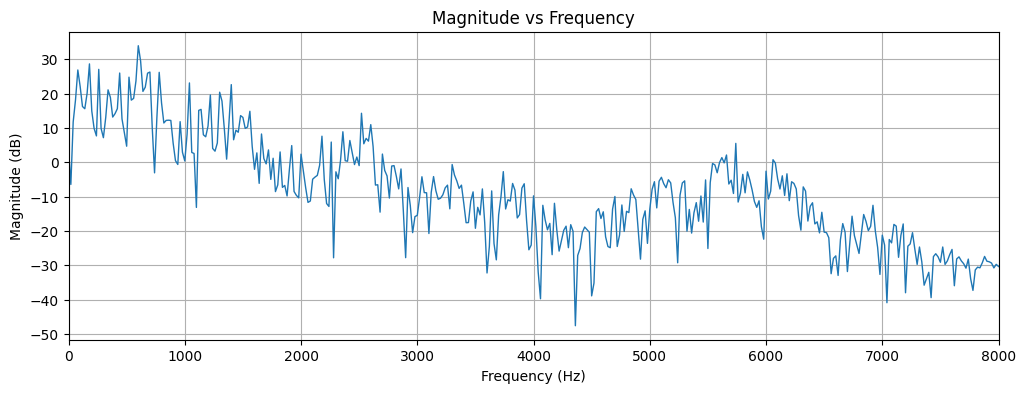

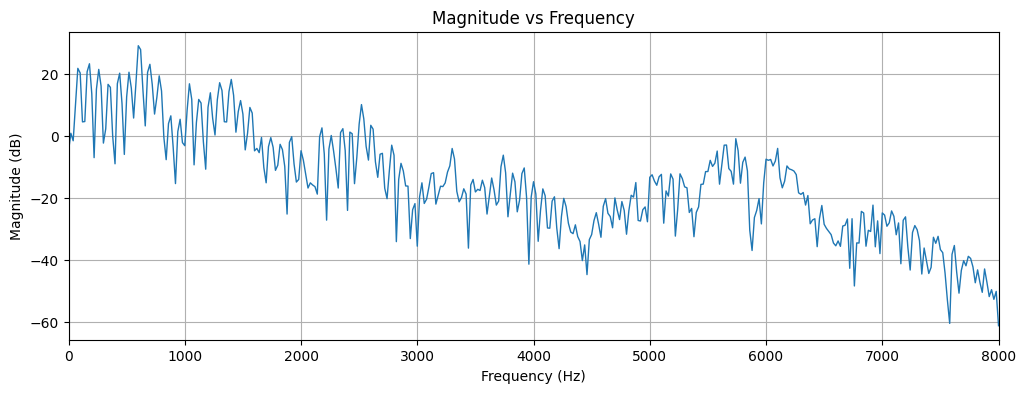

In [47]:
# TODO: Spectrum for voiced segment
f_rect, mag_rect = magnitude_spectrum(x_seg, fs, window=None)
f_hann, mag_hann = magnitude_spectrum(x_seg, fs, window="hann")
# Plot both (separately or overlay)
plot_spectrum(f_rect,mag_rect)
plot_spectrum(f_hann,mag_hann)

### Questions (Voiced speech spectrum)

1. Do you see harmonic peaks? Estimate the spacing (≈ F0). What is your estimated F0?  
2. Describe the spectral envelope: where are the broad peaks (formant-like regions)?  
3. How does windowing change the appearance of the harmonics and envelope?


### Answers

1. I do see harmonic peaks with F0 estimated 600-700.
2. Broad peaks appeared where there where multiple smaller peaks. This can be seen between 6k-7k Hz in the graphs above.
3. The peaks are rounder and wider in the hanning window. The harmonics are wider and the envelope is gradual.

## 3.3 Unvoiced / fricative segment (optional but recommended)

### Task
Pick a 30–50 ms segment that is unvoiced (e.g., /s/ or /f/ region, if present).
Compute spectrum and compare to voiced.

Answer: how does the spectrum differ?


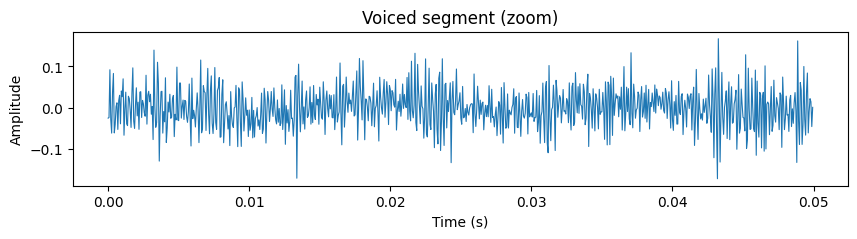

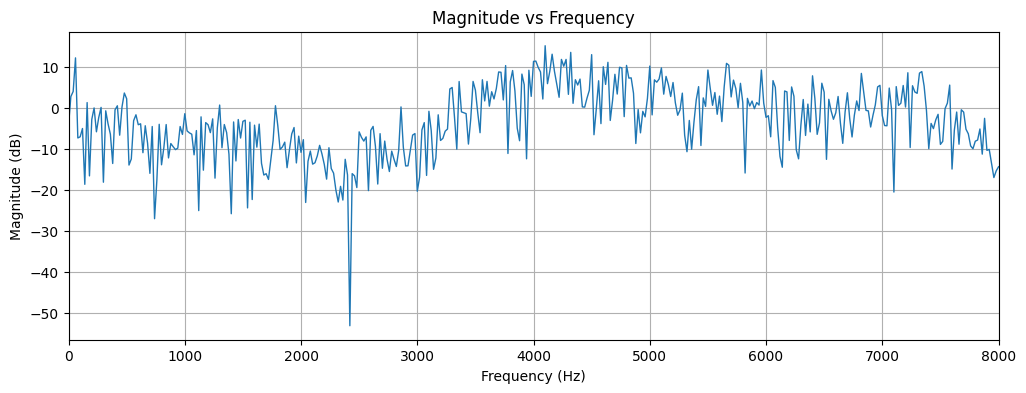

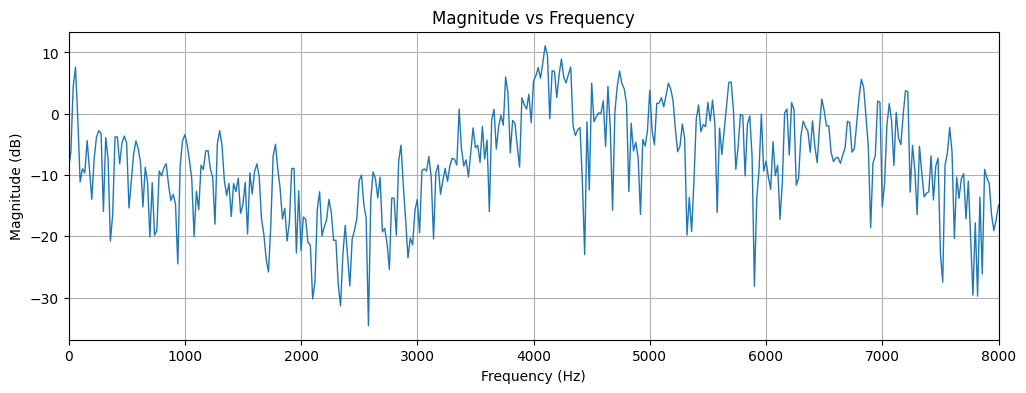

In [53]:
# TODO: Choose unvoiced segment times and repeat the spectrum analysis
t_start_u = 2.4
t_end_u = 2.45
n0 = int(t_start_u*fs); n1 = int(t_end_u*fs)
x_seg_u = x[n0:n1]

plot_waveform(x_seg_u, fs, "Voiced segment (zoom)")
display(Audio(x_seg_u, rate=fs))

f_rect, mag_rect = magnitude_spectrum(x_seg_u, fs, window=None)
f_hann, mag_hann = magnitude_spectrum(x_seg_u, fs, window="hann")
# Plot both (separately or overlay)
plot_spectrum(f_rect,mag_rect)
plot_spectrum(f_hann,mag_hann)

### Questions (Unvoiced vs voiced)

- What is different about the spectrum of unvoiced speech?
- Do you still see harmonic structure? Why or why not?
- Where is most of the energy concentrated (low vs high frequencies)?


### Answers

- The hanning window had more noticeable effects on the unvoiced speech. There are more wide/rounded areas compared to the voiced.
- The harmonic structure is gone because this is unvoiced and does not have the harmonic structure that voiced has.
- Most of the energy has in higher frequencies.

---

# 4. Short-Time Fourier Transform View (Spectrogram) - Optional

### Task
Plot a spectrogram of your full utterance with reasonable parameters:
- window length: ~25 ms
- hop: ~10 ms
- display in dB

Then answer conceptual questions.


In [ ]:
# TODO: Spectrogram helper (STFT)
def plot_spectrogram(x, fs, title, n_fft=1024, win_ms=25, hop_ms=10):
    raise NotImplementedError


In [ ]:
# TODO: Plot spectrogram
# plot_spectrogram(x, fs, "Spectrogram of utterance")


### Questions (Spectrogram intuition)

1. Where do you see voiced regions vs unvoiced regions in the spectrogram?  
2. How does the spectrogram reveal formants (broad bands)?  
3. If you increase window length to 50 ms, what changes? (Try and explain.)  
4. If you decrease hop size, what changes? (Try and explain.)


---

# 5. Summary: What Fourier View Gives You

Write 8–12 lines:

- What information is easiest to see in time domain?
- What information is easiest to see in frequency domain?
- For speech, why do we often use a short-time (frame-based) spectrum instead of one FFT on the whole signal?


### Answers

- It is easiest to see changes in amplitude in the time domain. This lets us see patterns, voiced/unvoiced, and other qualities that depend on temporal ordering.
- We can see the effects of the window in the frequency domain. We can also easily observe harmonics since we plot magnitude vs frequency.
- Speech naturally depends on temporal ordering so if we analyze a small frame we can look at spectral changes over time. FFT averages out temporal information so by only doing short-time we can keep some of the information.

---

# 6. Reflection (Mandatory)

Write thoughtful answers (be specific):

1. What did you learn about FFT/DFT that you did not expect?  
2. What was one surprising result about windows or leakage?  
3. Which plot helped you the most (waveform, spectrum, spectrogram) and why?  
4. If you had to explain “frequency resolution” in two sentences, what would you say?  
5. What is one question you now want to explore further (e.g., formant tracking, pitch estimation)?


### Answers

1. I did not expect to learn the visual effects of widening peaks as I do not have much DSP background.
2. I was surprised by the intuition behind the window and short-time processing. 
3. The spectrum helped the most because I could visually see the widening effects.
4. I would say that it's how we distinguish signals that are close in frequency.
5. I would want to explore pitch estimation and its real world applications.

---

# 7. AI Use Disclosure (Required)

If you used any AI tools (including ChatGPT), briefly describe:
- What you used it for (e.g., debugging, concept clarification)
- What you wrote/changed yourself

*(If you did not use AI, write “No AI tools used.”)*


I used AI to generate the table.

I used AI to understand some concepts such as bins.